<a href="https://colab.research.google.com/github/BastLast/DeepLearning/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Deep learning

Girardin Florian, Lasteyrie Bastien, Senet Alexandre - *Tim Roquette*

## Première réflexion :

Notre première liste de stratégies pour le challenge numéro 1 est la suivante :

- CNN simple

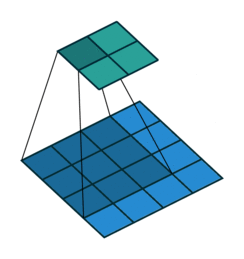

- CNN avec dilation

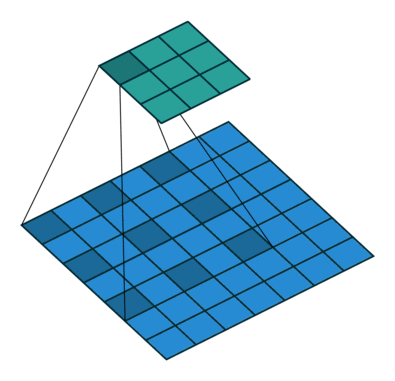

Notre théorie est que cette stratégie serait plus efficace sur les images fortement altérées

- Utiliser un modèle existant (DRU net nous semble interessant en première instance)

- Nous serions également curieux de savoir quel seraient les performance sur les images peu dégradées d'un modèle entrainé sur des images fortement dégradées
et inversement.

## Pistes étudiées :

https://github.com/cszn/DnCNN


https://github.com/SonghyunYu/DIDN


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

import numpy as np

import time

torch.manual_seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [16]:
def importDataset() :
  from google.colab import drive
  drive.mount('/content/drive')

  from google.colab import files
  import zipfile
  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Tiny/train_tiny_1A.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Tiny")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Tiny/train_tiny_1B.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Tiny")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Tiny/train_tiny_2.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Tiny")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Test/test.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Test")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Full/train_1A.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Full")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Full/train_1B.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Full")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Full/train_2.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Full")


#Uncomment the function below to import the dataset 
#importDataset()


In [17]:
class CustomModel(torch.nn.Module):

  def __init__(self):
    super(LeNet5, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), stride=1, padding=2, bias=False)
    self.relu1 = torch.nn.ReLU()
    self.avgpool1 = torch.nn.AvgPool2d(2, stride=2)
    # initialize second set of CONV => RELU => POOL layers
    self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=1, padding=0, bias=False)
    self.relu2 = torch.nn.ReLU()
    self.avgpool2 = torch.nn.AvgPool2d(2, stride=2)
    # initialize third set of CONV => RELU
    self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), stride=1, padding=0, bias=False)
    self.relu3 = torch.nn.ReLU()
    # initialize first set of linear => RELU layers
    self.flatten = torch.nn.Flatten()
    self.f1 = torch.nn.Linear(in_features=120, out_features=84)
    self.relu4 = torch.nn.ReLU()
    # initialize second set of linear
    self.f2 = torch.nn.Linear(in_features=84, out_features=10)
    pass
  
  def forward(self, x):
    """
      :param: x : the image to process ( shape [batch_size, 1, height, width] )
      :return: logits: the unscaled output scores that will be process by the softmax ( shape [batch_size, D_out] )
    """
    # pass the input through our first set of CONV => RELU =>
		# POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.avgpool1(x)
    # pass the output from the previous layer through the second
    # set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.avgpool2(x)
    # pass the output from the previous layer through the third
    # set of CONV => RELU => POOL layers
    x = self.conv3(x)
    x = self.relu3(x)
    # flatten the output from the previous layer and pass it
    # through our first set of linear
    x = self.flatten(x)
    x = self.f1(x)
    x = self.relu4(x)
    # pass the output to our second set of linear
    # predictions
    x = self.f2(x)
    # return the output predictions
    return x

In [18]:
def train_optim(model, device, epochs, log_frequency, learning_rate=1e-4):

  model.to(device) # we make sure the model is on the proper device

  # Multiclass classification setting, we use cross-entropy
  # note that this implementation requires the logits as input 
  # logits: values prior softmax transformation 
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  for t in range(epochs):

      model.train() # we specify that we are training the model

      start=time.time() #start timer

      # At each epoch, the training set will be processed as a set of batches
      for batch_id,  batch in enumerate(trainloader) : 

        images, labels  = batch

        # we put the data on the same device
        images , labels = images.to(device), labels.to(device)  
        
        y_pred = model(images) # forward pass output=logits

        loss = loss_fn(y_pred, labels)

        if batch_id % log_frequency == 0:
            print("epoch: {:03d}, batch: {:03d}, loss: {:.3f}, time: {:.3f}".format(t+1, batch_id+1, loss.item(),time.time()-start))

        optimizer.zero_grad() # clear the gradient before backward
        loss.backward()       # update the gradient

        optimizer.step() # update the model parameters using the gradient

      # Model evaluation after each step computing the accuracy
      model.eval()
      total = 0
      correct = 0
      for batch_id, batch in enumerate(testloader):
        images , labels = batch
        images , labels = images.to(device), labels.to(device)
        y_pred = model(images) # forward computes the logits
        sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
        _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [19]:
#Dataloader
class LoadImages(Dataset):
    def __init__(self, transformed_dataset_path : str, original_dataset_path : str) -> None:
        super(LoadImages, self).__init__()
        
        self.transformed_dataset_path = transformed_dataset_path
        self.original_dataset_path = original_dataset_path

        e1 = np.load(original_dataset_path)
        
        self.original_dataset = np.reshape(e1, (-1, 3, 96, 96))
        
        e2 = np.load(transformed_dataset_path)
        self.transformed_dataset = np.reshape(e2, (-1, 3, 96, 96))
        
        self.size = len(self.original_dataset)
            
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.transformed_dataset[idx], self.original_dataset[idx])

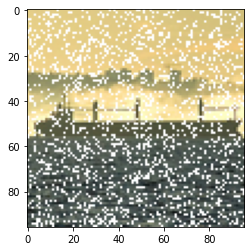

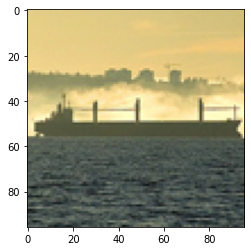

In [24]:
o_dataset = "/content/drive/MyDrive/dataset/Tiny/train_original_tiny.npy"
t_dataset =  "/content/drive/MyDrive/dataset/Tiny/train_1A_tiny.npy"
batch_size = 32
dataset = LoadImages(t_dataset, o_dataset)

dataloader = DataLoader(dataset,batch_size,shuffle=True)

for batch in dataloader:
    t_img, o_img = batch
    
    plt.figure(1)
    plt.imshow(t_img[0].permute(1,2,0))
    plt.figure(2)
    plt.imshow(o_img[0].permute(1,2,0))
    plt.show()

    break     

**Crédit des illustrations :** https://github.com/vdumoulin/conv_arithmetic